# Example for the Audio Siamese model

This notebook shows the core power of `siamese networks` : the ability to generalize to unseen labels !

The idea is the following : 
1. Split the `common_voice` + `voxforge` datasets (or `LibriSpeech`) in 2 subsets where **all** speakers are different (i.e. no speaker from valid set is in the train set and vice-versa)
2. Create *siamese dataset format* for both subsets
3. Preload a large amount of audios : siamese datasets work with pairs of same / not same. The same datas appears in multiple pairs. To avoid reloading multiple times the same data, we cache them ! It is the reason why I use an `AudioSiameseGenerator` as dataset (it also works without but it is far slower). 
4. Train the model on the `train_set` and evaluate it on `valid_set`. Reminder : **all** validation metrics will be on **new labels** (new speakers)
5. Make funny plots !

Performance note : when caching 100% of the dataset I achieve a 400ms/batch performance while a 2s/batch when loading a smaller part (and far more if not using the generator).

*Raw Audio* vs *Mel spectrogram* input : both are really performant (maybe raw audio is slighly better) but it seems that `mel-based` models are better to use in the `SV2TTS` architecture (cf https://github.com/yui-mhcp/text_to_speech project).  

## Imports + model initialization

In [1]:
import time
import numpy as np
import pandas as pd
import tensorflow as tf

from tqdm import tqdm
from sklearn.utils import shuffle as sklearn_shuffle

from models.siamese import AudioSiamese
from custom_train_objects import AudioSiameseGenerator
from utils import plot, plot_multiple, plot_embedding, plot_confusion_matrix, set_display_options, sample_df
from datasets import get_dataset, prepare_dataset, train_test_split, test_dataset_time

set_display_options()

model_name = 'audio_siamese_256_mel_lstm'

print("Tensorflow version : {}".format(tf.__version__))

Tensorflow version : 2.6.2


In [2]:
input_type = 'mel'
config = {
    'audio_format'  : input_type,
    'audio_rate'    : 22050,
    'use_fixed_length_input' : False,
    'embedding_dim' : 256,
    
    'normalize' : True,
    'max_audio_time' : 5,
    'flatten_type' : 'lstm' if input_type == 'mel' else 'max',
    'final_activation' : 'relu'
}

model = AudioSiamese(nom = model_name, ** config)

print(model)
#model.encoder.summary()

Initializing model with kwargs : {'siamese': {'architecture_name': 'siamese', 'model': <keras.engine.sequential.Sequential object at 0x000001C83EC77A58>, 'distance_metric': 'euclidian', 'input_shape': (None, 80)}}
Initializing submodel : `siamese` !
Submodel siamese saved in pretrained_models\audio_siamese_256_mel_lstm\saving\siamese.json !
Model audio_siamese_256_mel_lstm initialized successfully !

========== audio_siamese_256_mel_lstm ==========
Sub model siamese
- Inputs 	: [(None, None, 80), (None, None, 80)]
- Outputs 	: (None, 1)
- Number of layers 	: 4
- Number of parameters 	: 2.667 Millions
- Model not compiled

Already trained on 0 epochs (0 steps)

Embedding dim : 256
Distance metric : euclidian
- Audio rate : 22050
- # mel channels : 80



## Model instanciation + dataset loading

The `RMSProp` optimizer seems to give faster result than `Adam` but no rigorous comparison. 

In [2]:
model = AudioSiamese(nom = model_name)

#model.compile(
#    optimizer = 'adam', 
#    optimizer_config = {
#        'lr' : {'name' : 'WarmupScheduler', 'maxval' : 1e-3,'minval' : 1e-4, 'factor' : 256, 'warmup_steps' : 4096}
#    }
#)
model.compile(optimizer = 'rmsprop')
print(model)

`mel_fn_type` is deprecated, please use `mel_fn` to specify the Mel class / file or call `save_config()` to update the config file
Model restoration...
Initializing submodel : siamese !
Optimizer 'siamese_optimizer' initilized successfully !
Successfully restored siamese from pretrained_models/audio_siamese_256_mel_lstm/saving/siamese.json !
Model audio_siamese_256_mel_lstm initialized successfully !
Model siamese is already compiled !

========== audio_siamese_256_mel_lstm ==========
Sub model siamese
- Inputs 	: [(None, None, 80), (None, None, 80)]
- Outputs 	: (None, 1)
- Number of layers 	: 7
- Number of parameters 	: 2.667 Millions
- Optimizer 	: {'name': 'RMSprop', 'learning_rate': 9.999999747378752e-05, 'decay': 0.0, 'rho': 0.8999999761581421, 'momentum': 0.0, 'epsilon': 1e-07, 'centered': False}
- Loss 	 : {'reduction': 'auto', 'name': 'binary_crossentropy', 'from_logits': False, 'label_smoothing': 0, 'axis': -1}
- Metrics	 : [{'name': 'binary_accuracy', 'dtype': 'float32', 'th

## Dataset loading

I left the 3 options for dataset : french only (`CommonVoice + VoxForge`), english only (`LLibriSpeech`) or a mixture of both. You just have to execute one of them for training / testing.

In [ ]:
preload = False
datasets = ['common_voice', 'voxforge']

dataset = get_dataset(datasets)
train, valid = train_test_split(dataset, valid_size = 256, split_by_unique = True)

train = AudioSiameseGenerator(
    train, rate = model.audio_rate, mel_fn = model.mel_fn, nb_unique = 768, preload = preload,
    cache_size = 50000, random_state = 10
)
valid = AudioSiameseGenerator(
    valid, rate = model.audio_rate, mel_fn = model.mel_fn, nb_unique = 256, preload = True
)

print("Dataset length :\n  Training set : {}\n  Validation set : {}".format(
    len(train), len(valid)))

In [3]:
ds = 'librispeech'
preload = True

dataset = get_dataset(ds, shuffle = True)
train, valid = dataset['train'], dataset['valid']

train = AudioSiameseGenerator(
    train, rate = model.audio_rate, mel_fn = model.mel_fn, nb_unique = 256, max_by_id = 100,
    cache_size = 75000, min_apparition = 1, shuffle = True, preload = preload, random_state = 10, tqdm = tqdm
)
valid = AudioSiameseGenerator(
    valid, rate = model.audio_rate, mel_fn = model.mel_fn, nb_unique = 40, preload = preload, shuffle = False, tqdm = tqdm
)

print("Dataset length :\n  Training set : {}\n  Validation set : {}".format(len(train), len(valid)))

Loading dataset librispeech...


100%|██████████████████████████████████████████████████████████████████████████████| 2439/2439 [03:28<00:00, 11.71it/s]

Dataset length :
  Training set : 25600
  Validation set : 4000


In [ ]:
def concat(ds1, ds2):
    ds = pd.concat([ds1, ds2], ignore_index = True).dropna(axis = 'columns')
    ds = sklearn_shuffle(ds, random_state = 10)
    return ds

preload = False
fr_ds = ['common_voice', 'voxforge']

libri_speech = get_dataset('librispeech', shuffle = True)
fr_datasets  = get_dataset(fr_ds, shuffle = True)

libri_train, libri_valid = libri_speech['train'], libri_speech['valid']
fr_train, fr_valid = train_test_split(fr_datasets, valid_size = 260, split_by_unique = True, shuffle = True)

train, valid = concat(libri_train, fr_train), concat(libri_valid, fr_valid)

train = AudioSiameseGenerator(
    train, rate = model.audio_rate, mel_fn = model.mel_fn, nb_unique = 2048, max_by_id = 100,
    cache_size = 100000, min_apparition = 1, shuffle = True, preload = preload, random_state = 10, tqdm = tqdm
)
valid = AudioSiameseGenerator(
    valid, rate = model.audio_rate, mel_fn = model.mel_fn, nb_unique = 300, preload = preload, shuffle = False, tqdm = tqdm
)

print("Dataset length :\n  Training set : {}\n  Validation set : {}".format(len(train), len(valid)))

In [ ]:
print(train, '\n')
print(valid)

print("Number of ids in valid also in train : {}".format(
    sum([valid_id in train.ids for valid_id in valid.ids])
))
print("Number of ids in train also in train (to test) : {}".format(
    sum([train_id in train.ids for train_id in train.ids])
))


This cell is to re-build a new dataset with (more ?) speakers / data and re-build the cache

In [44]:
train.build_datasets(nb_unique = 1024, max_by_id = 250, tqdm = tqdm)
_ = train.build_cache(135000, 1, preload = True)

100%|██████████████████████████████████████████████████████████████████████████████| 8868/8868 [18:30<00:00,  7.99it/s]


These 2 cells can be used to pickle pre-loaded data (which can save some time if you want to re-train your model)

In [7]:
import pickle

with open('libri_cache.pkl', 'wb') as file:
    pickle.dump(train.cache, file)

In [ ]:
import pickle

with open('libri_256_100.pkl', 'rb') as file:
    train.cache = pickle.load(file)

## Training

Note that `cache = False` and `shuffle_size = 0` are recommanded to not waste memory / time as the `generator` already caches the right amount of file (to not overload your memory) and shuffle the whole dataset at every epoch. 

**Important** : it is possible that during 5-10 epochs the loss does not change at all. The reason is that the model has to learn the right parameters to separate datas between `same` and `not same` which can take some time (especially with `Adam`, `RMSProp` seems to speed up this learning). 

### History analysis 

As you can see, there is 3 phases in the training where epochs becomes longer (more steps). The reason is that I progressively increased the number of unique speaker in the dataset (256, 512 then 1024).

At epoch 40, I stopped training (from 512 speakers) to increase it to 1024 as it started to be unstable (it is the hole in the validation history). 

Also note that in validation dataset there was only 40 speakers so the accuracy is more unstable than training which as far more data.

In [46]:
epochs = 10
batch_size = 16

print("Training samples   : {} - {} batches".format(len(train), len(train) // batch_size))
print("Validation samples : {} - {} batches".format(len(valid), len(valid) // (batch_size * 2)))

hist = model.train(
    train, validation_data = valid, 
    epochs = epochs, batch_size = batch_size, valid_batch_size = 2.,
    cache = False, shuffle_size = 0, augment_prct = 0.25
)

Training samples   : 256000 - 16000 batches
Validation samples : 4000 - 125 batches
Training config :
HParams :
- augment_prct	: 0.25
- epochs	: 50
- batch_size	: 16
- valid_batch_size	: 2.0
- test_batch_size	: 1
- verbose	: 1
- train_times	: 1
- valid_times	: 1
- train_size	: None
- valid_size	: None
- test_size	: 4
- pred_step	: -1
- shuffle_size	: 0

Epoch 41/50
  16000/Unknown - 1311s 82ms/step - loss: 0.1880 - siamese_BinaryAccuracy: 0.9282 - EER: 0.0714 - AUC: 0.9779
Saving at epoch 41 !

Making prediction at step 192000
16000/16000 [==============================] - 1358s 85ms/step - loss: 0.1880 - siamese_BinaryAccuracy: 0.9282 - EER: 0.0714 - AUC: 0.9779 - val_loss: 0.2652 - val_siamese_BinaryAccuracy: 0.9055 - val_EER: 0.0961 - val_AUC: 0.9605
Epoch 42/50
16000/16000 [==============================] - ETA: 0s - loss: 0.1803 - siamese_BinaryAccuracy: 0.9311 - EER: 0.0693 - AUC: 0.9795
Making prediction at step 208000
16000/16000 [==============================] - 1338s 84ms/st

In [ ]:
model.plot_history()

## Evaluation

**Important** : this testing was done with an older model and not the one trained above.

Explaination : on the metrics you can see `{test_ / val_ / } metric_name` : 
- The `test_` prefix is for testing (testing outside the training loop)
- The `val_` prefix is for the validation metrics (validation set during training)
- The metric without prefix is for the training metrics

They are all shown in the final print of the `ProgressBar` callback because the `on_epoch_end()` is called with all metrics in `model.history` for this epoch (and then all metrics from training)

During the testing progression, only `test_` metrics are shown

It is a technical reason but important to explain it to avoid confusion ;)

I decided to separate `test_` and `val_` prefix for 2 main reasons : 
1. It allows to separate validation and testing which can be done on different datasets
2. Allow to test on other metrics (other than those used for training / validation) without modifying the validation metrics (not well supported yet)

Indeed, as you use the validation set to fine-tune your model parameters, this set is not *completely* independant from your model / training procedure so testing on completely new datasets can be interesting !

Here I made the testing on `valid` which is *theorically speaking* not a good idea but it is just a demonstration.

A good idea could be to test the model on `LibriSpeech` while training / validating it on `common_voice` and `voxforge`  (or the opposit).

As a side note : you can see the `testing config` contains `augment_prct` but in theory this parameter is **not** used in validation / testing so it is here just because it is a `training hyperparameter` but it is not used here

In [7]:
h = model.test(valid)

Testing config :
HParams :
- augment_prct	: 0.25

267/267 [==============================] - 9s 33ms/step - test_loss: 0.2271 - test_siamese_BinaryAccuracy: 0.9096 - test_EER: 0.0819 - test_AUC: 0.9694 - loss: 0.1732 - siamese_BinaryAccuracy: 0.9336 - EER: 0.0679 - AUC: 0.9806 - val_loss: 0.2774 - val_siamese_BinaryAccuracy: 0.9028 - val_EER: 0.0966 - val_AUC: 0.9598
Testing lasted 11.847 sec !


## Embedding

What we can see in this plot : 
- Many color points in a black background : quite beautiful ! :D (points correspond to embedded audio while colors represent speakers)
- We can observe clusters of points which are clearly identified and far away from other clusters
- Some speakers seems to be hard to distinguish (points in the middle-right) : here can be some hypothesis
    - Speakers have similar voices
    - Audios are bad quality (noisy, ...) which can make the representation harder* (especially possible for the 2nd demonstration on `VoxForge`)

Reminder : **all these speakers are totally unknown** ! The model **never** saw them in its training data

Note : the model was trained on 50 epochs (less than 10h training on single GPU) and have a 90% binary accuracy on totally unseen datas, really impressive !

**Important Note** : the 90% binary accuracy is **not** the real model performance but an estimation. Indeed its performance is computed on 40 speakers each 100 pairs `same` and `not-same` but it does **not** represent all possible pairs of data / speakers ! 

*`common_voice` and `voxforge` are datasets suited for `Text-To-Speech` and are not perfect quality audio : there is noise, bad quality recording, voice intensity highly variable, ... 

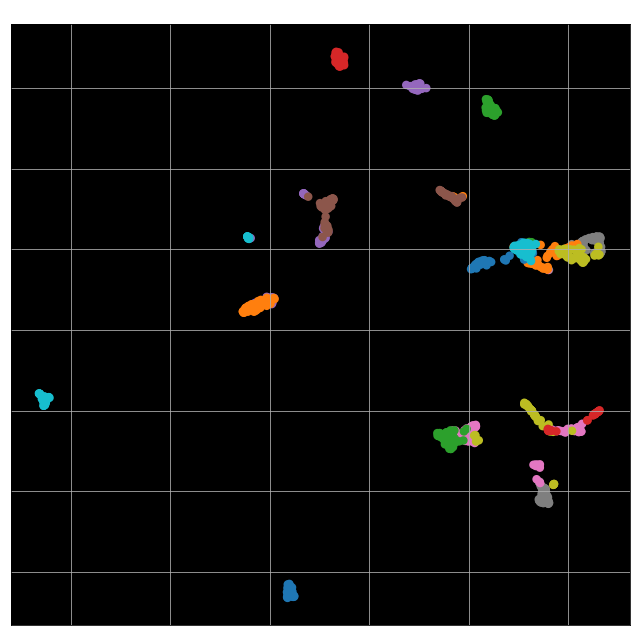

In [50]:
ids = valid.ids[:20]
samples = valid.sample(50, ids = ids)

model.plot_embedding(samples)

This second demonstration is even more impressive because audios are taken from the `VoxForge` french dataset while the model has been trained on `LibriSpeech` English dataset !

Loading dataset voxforge...


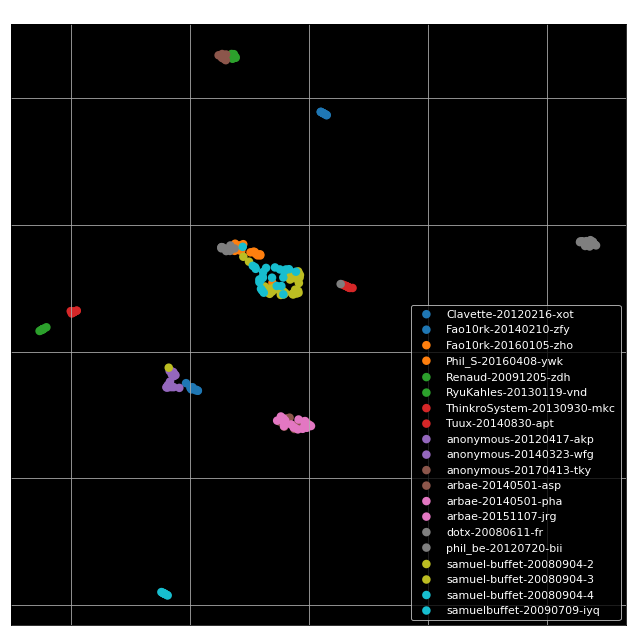

In [4]:
voxforge = get_dataset('voxforge')
samples = sample_df(voxforge, n = 20, n_sample = 25)

model.plot_embedding(samples)

## Identify on file

This feature allow to detect speakers in an audio and group parts of the audio where this speaker is speaking. 

This is an example of result on an interview (i.e. 2 speakers). You can see that it detects more than 2 speakers.
The model is clearly not perfect and can make mistakes (and did some but they are more *inside* a cluster) : some additional clusters are for speakers with some artifacts but a complete cluster is for music !


Processing file interview_resampled.mp3...


100%|███████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 998.74it/s]


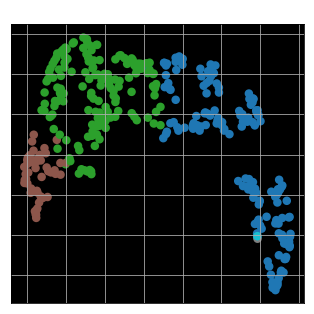

Saving to directory pretrained_models\audio_siamese_256_mel_lstm\identification\results\interview_resampled_result
Saving data to pretrained_models\audio_siamese_256_mel_lstm\identification\results\interview_resampled_result\config.json
Annotation of file interview_resampled.mp3 :
- Total annotation time : 30min 28sec
- Number of alignments : 366 (366 sub-parts)
- Speakers (n = 5) : [0, 1, 2, 4, 5]



In [9]:
filename = 'interview_resampled.mp3'

result = model.identify(
    filename, step = 5., threshold = 0.7, min_threshold = 0.5, show = True, overwrite = True,
    should_combine = False, min_cluster_size = 0, fusion_threshold = 2.
)[0]

print(result)
#result.set_names()

In [ ]:
result.set_names()

## Embedding dataset

This is the code I used to embed my datasets to use them in the `sv2tts` architecture

Model restoration...
Initializing submodel : siamese !
Optimizer 'siamese_optimizer' initilized successfully !
Submodel siamese compiled !
  Loss : {'reduction': 'auto', 'name': 'binary_crossentropy', 'from_logits': False, 'label_smoothing': 0}
  Optimizer : {'name': 'RMSprop', 'learning_rate': 9.999999747378752e-05, 'decay': 0.0, 'rho': 0.8999999761581421, 'momentum': 0.0, 'epsilon': 1e-07, 'centered': False}
  Metrics : [{'name': 'binary_accuracy', 'dtype': 'float32', 'threshold': 0.5}, {'name': 'EER', 'dtype': 'float32', 'num_thresholds': 200, 'curve': 'ROC', 'summation_method': 'interpolation', 'thresholds': [0.005025125628140704, 0.010050251256281407, 0.01507537688442211, 0.020100502512562814, 0.02512562814070352, 0.03015075376884422, 0.035175879396984924, 0.04020100502512563, 0.04522613065326633, 0.05025125628140704, 0.05527638190954774, 0.06030150753768844, 0.06532663316582915, 0.07035175879396985, 0.07537688442211055, 0.08040201005025126, 0.08542713567839195, 0.0904522613065326

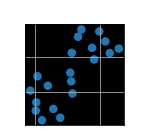

Loading dataset voxforge...
Dataset already processed !
                                                filename  \
0      D:/datasets/VoxForge\fr\4h-20100505-vgm\wav\fr...   
1      D:/datasets/VoxForge\fr\4h-20100505-vgm\wav\fr...   
2      D:/datasets/VoxForge\fr\4h-20100505-vgm\wav\fr...   
3      D:/datasets/VoxForge\fr\4h-20100505-vgm\wav\fr...   
4      D:/datasets/VoxForge\fr\4h-20100505-vgm\wav\fr...   
...                                                  ...   
22664  D:/datasets/VoxForge\fr\ZG-20130526-fbb\wav\fr...   
22665  D:/datasets/VoxForge\fr\ZG-20130526-fbb\wav\fr...   
22666  D:/datasets/VoxForge\fr\ZG-20130526-fbb\wav\fr...   
22667  D:/datasets/VoxForge\fr\ZG-20130526-fbb\wav\fr...   
22668  D:/datasets/VoxForge\fr\ZG-20130526-fbb\wav\fr...   

                                               embedding               id  
0      [0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0...  4h-20100505-vgm  
1      [0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0...  4h-20100505-v

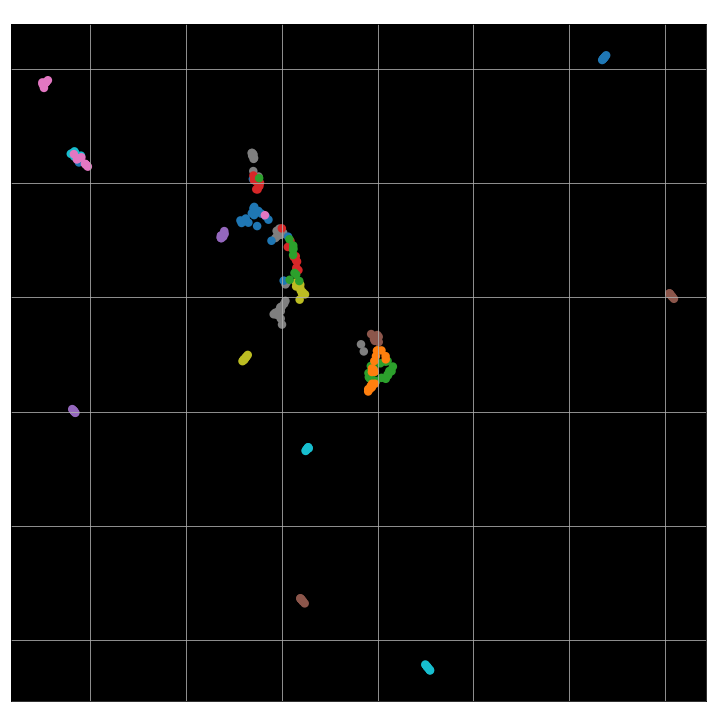

Loading dataset common_voice...
Dataset already processed !
                                                 filename  \
0       D:/datasets/CommonVoice\clips\common_voice_fr_...   
1       D:/datasets/CommonVoice\clips\common_voice_fr_...   
2       D:/datasets/CommonVoice\clips\common_voice_fr_...   
3       D:/datasets/CommonVoice\clips\common_voice_fr_...   
4       D:/datasets/CommonVoice\clips\common_voice_fr_...   
...                                                   ...   
236670  D:/datasets/CommonVoice\clips\common_voice_fr_...   
236671  D:/datasets/CommonVoice\clips\common_voice_fr_...   
236672  D:/datasets/CommonVoice\clips\common_voice_fr_...   
236673  D:/datasets/CommonVoice\clips\common_voice_fr_...   
236674  D:/datasets/CommonVoice\clips\common_voice_fr_...   

                                                embedding  \
0       [0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0...   
1       [0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, -0.0, 0.0...   
2       [0.0, 0.0, 0.0, 

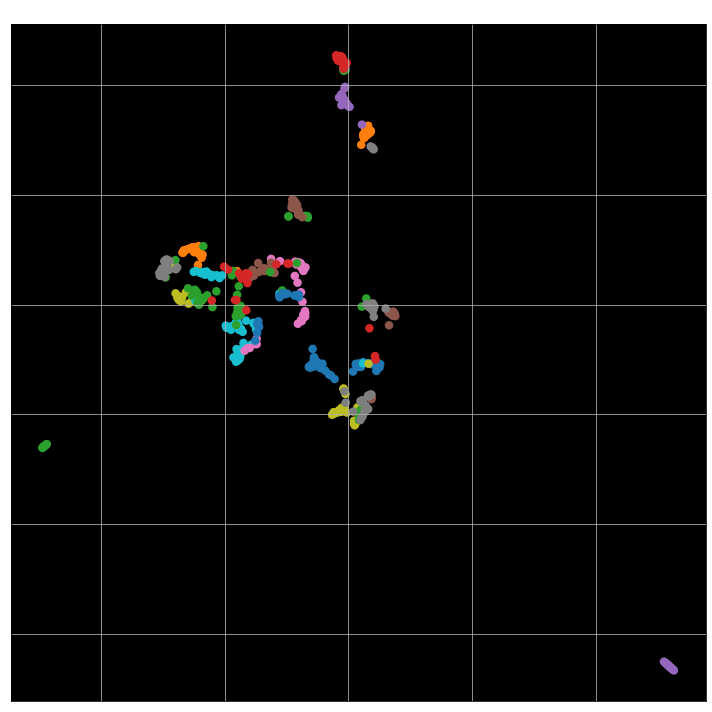

In [2]:
model = AudioSiamese(nom = model_name)

if not model.use_fixed_length_input: model.max_audio_time = 10.

audio_kwargs = {
    'trim_silence'  : True,
    'reduce_noise'  : True,
    'method'        : 'window',
    'mode'          : 'start_end',
    'threshold' : 0.075,
}

list_ds = [
#    ('mls', 'D:/datasets/MLS/fr'),
    ('siwis',        'D:/datasets/SIWIS/fr'),
    ('voxforge',     'D:/datasets/VoxForge'),
    ('common_voice', 'D:/datasets/CommonVoice')
]
for name, path in list_ds:
    ak = {} #if name != 'common_voice' else audio_kwargs
    
    ds = get_dataset(name)
    
    if isinstance(ds, dict):
        for mode in ['train', 'valid']:
            ds_mode = ds[mode]
            if mode == 'valid': mode = 'test'
            res = model.embed_dataset(
                os.path.join(path, mode), ds_mode, batch_size = 1, save_every = 4000, max_audios = 2500,
                embedding_name = 'embeddings_256_mel_lstm.csv'
            )
            print(res)
    else:
        res = model.embed_dataset(
            path, ds, batch_size = 1, save_every = 15000, max_audios = 8000, audio_kwargs = ak,
            embedding_name = 'embeddings_256_mel_lstm.csv'
        )
        print(res)
        plot_embedding(sample_df(res, n = 25, n_sample = 20))


## Preprocessing

This cell allows you to resample your dataset if you want a specific sampling rate

This can be really useful in order to avoid resampling (which is quite slow) at every training time

In [1]:
from datasets.custom_datasets import resample_librispeech

path = 'D:/datasets/LibriSpeech'
resample_librispeech(path, 22050, subset = ['test-clean', 'train-clean-100', 'train-clean-360'])

0it [00:00, ?it/s]

Resampling dataset to 22050
  2620 files already processed
  0 files to process



0it [00:00, ?it/s]

Resampling dataset to 22050
  28539 files already processed
  0 files to process



0it [00:00, ?it/s]

Resampling dataset to 22050
  104014 files already processed
  0 files to process


,filename,text,id,total_time,name,sex,wavs_22050,wavs_16000
0,D:/datasets/LibriSpeech\train-clean-360\14\208...,Chapter eleven the morrow brought a very sober...,14,25.03,Kristin LeMoine,F,D:/datasets/LibriSpeech\wavs_22050_train-clean...,D:/datasets/LibriSpeech\train-clean-360\14\208...
1,D:/datasets/LibriSpeech\train-clean-360\14\208...,Declined giving any absolute promise of sunshi...,14,25.03,Kristin LeMoine,F,D:/datasets/LibriSpeech\wavs_22050_train-clean...,D:/datasets/LibriSpeech\train-clean-360\14\208...
2,D:/datasets/LibriSpeech\train-clean-360\14\208...,At about eleven o'clock however a few specks o...,14,25.03,Kristin LeMoine,F,D:/datasets/LibriSpeech\wavs_22050_train-clean...,D:/datasets/LibriSpeech\train-clean-360\14\208...
3,D:/datasets/LibriSpeech\train-clean-360\14\208...,I thought how it would be said missus allen no...,14,25.03,Kristin LeMoine,F,D:/datasets/LibriSpeech\wavs_22050_train-clean...,D:/datasets/LibriSpeech\train-clean-360\14\208...
4,D:/datasets/LibriSpeech\train-clean-360\14\208...,It will be so dirty oh that will not signify i...,14,25.03,Kristin LeMoine,F,D:/datasets/LibriSpeech\wavs_22050_train-clean...,D:/datasets/LibriSpeech\train-clean-360\14\208...
...,...,...,...,...,...,...,...,...
104009,D:/datasets/LibriSpeech\train-clean-360\9026\2...,And the road was good especially for thugs whi...,9026,21.75,Tammy Porter,F,D:/datasets/LibriSpeech\wavs_22050_train-clean...,D:/datasets/LibriSpeech\train-clean-360\9026\2...
104010,D:/datasets/LibriSpeech\train-clean-360\9026\2...,It had simply changed from a poor man's camp t...,9026,21.75,Tammy Porter,F,D:/datasets/LibriSpeech\wavs_22050_train-clean...,D:/datasets/LibriSpeech\train-clean-360\9026\2...
104011,D:/datasets/LibriSpeech\train-clean-360\9026\2...,This meant shafts tunnels hydraulic machinery ...,9026,21.75,Tammy Porter,F,D:/datasets/LibriSpeech\wavs_22050_train-clean...,D:/datasets/LibriSpeech\train-clean-360\9026\2...
104012,D:/datasets/LibriSpeech\train-clean-360\9026\2...,Seeking the golden fleece of the hills as his ...,9026,21.75,Tammy Porter,F,D:/datasets/LibriSpeech\wavs_22050_train-clean...,D:/datasets/LibriSpeech\train-clean-360\9026\2...


## Tests

In [ ]:
config = model.get_dataset_config(batch_size = 16, is_validation = False, shuffle_size = 0)
ds = prepare_dataset(train, ** config, debug = True)

test_dataset_time(ds, steps = 50)

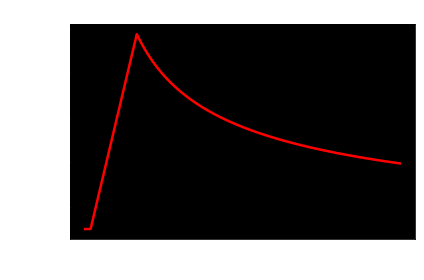

In [4]:
from custom_train_objects.optimizers import WarmupScheduler

lr = WarmupScheduler(maxval = 1e-3, minval = 1e-4, factor = 256, warmup_steps = 4096)
lr.plot(25000)